In [1]:
import lightkurve as lk
import numpy as np
import dynesty
import corner
import scipy 

In [2]:
kic = '12008916'

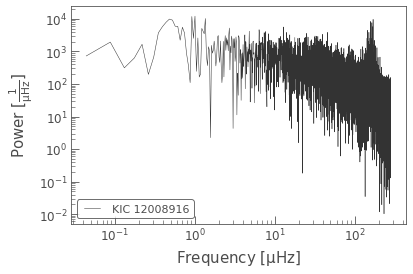

In [3]:
lc = lk.search_lightcurve('KIC ' + kic, author="Kepler", quarter=[8,9,10], cadence="long").download_all().stitch()
lc = lc.normalize()
lc.flux *= 1e6
pg = lc.to_periodogram(oversample_factor=1, normalization='PSD')
pg.plot(scale='log');

In [6]:
class dtwoterm():
    ''' At some point should JAX '''
    def __init__(self, pg):
        self.pg = pg
        self.f = self.pg.frequency.value
        self.O = self.pg.power.value
        self.f_dash = np.arange(self.f[0], self.f[-1] * 2, self.f[1] - self.f[0])
        print(self.f_dash)
        
    def harvey(self, a, b, c=4):
        return a**2 / b / (1 + (self.f_dash / b)**c)
    
    def eta(self):
        ''' TODO calculate just once'''
        x = np.pi * self.f_dash / 2 / self.f.max()
        return np.sin(x) / x
    
    def hump(self, numax, width, height):
        return height * np.exp(-0.5 * (self.f_dash - numax)**2 / width**2)
    
    def model(self, p): 
        a1, b1, a2, b2, numax, width, height, white = p
        mod = (self.harvey(a1, b1) + self.harvey(a2, b2) + self.hump(numax, width, height)) * self.eta()**2 + white
        return mod[:len(self.f)] + mod[-1:len(self.f)-1:-1]
    
    def expand(self, l):
        ''' From Kalinger 2014'''
        numax, white, delta_a1, delta_a2, delta_width, delta_height = l 
        p = [delta_a1 * 3382 * numax**-0.609, 
             0.317 * numax**0.970, 
             delta_a2 * 3382 * numax**-0.609, 
             0.948 * numax**0.992,
             numax, 
             delta_width * 0.3 * numax **0.8, 
             delta_height * 3335 * numax**-0.564, 
             white]
        return p
    
    def full_model(self, l):
        return self.model(self.expand(l))
    
    def loglike(self, l): 
        M = self.full_model(l)
        return -np.sum(np.log(M) + self.O/M)
    
    def ptform(self, u): 
        return [u[0] * 300, 
                u[1] * 1000,
                scipy.stats.norm.ppf(u[2]) * 0.3  + 1,
                scipy.stats.norm.ppf(u[3]) * 0.3  + 1,
                scipy.stats.norm.ppf(u[4]) * 0.5  + 1,
                scipy.stats.norm.ppf(u[5]) * 0.5  + 1]
    
    def __call__(self): 
        self.sampler = dynesty.NestedSampler(self.loglike, self.ptform, 6,
                               nlive=200)
        self.sampler.run_nested()
        res = self.sampler.results
        
        samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        new_samples = dynesty.utils.resample_equal(samples, weights)
        return new_samples
        

[4.36949147e-02 8.73898295e-02 1.31084744e-01 ... 5.66286095e+02
 5.66329790e+02 5.66373485e+02]


(10, 288)

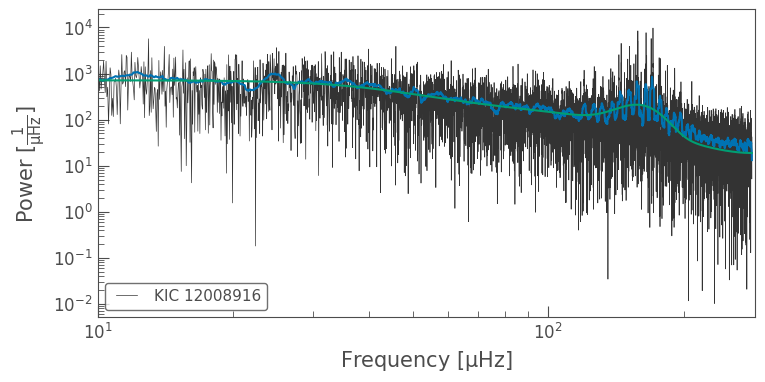

In [7]:
tt = dtwoterm(pg)

ax = pg.plot('log')
ax.plot(pg.frequency, pg.smooth(filter_width=2.0).power)
ax.plot(pg.frequency, tt.full_model([160, 5, 1., 1., 1., 1.]))
ax.set_xlim([10, 288])

In [8]:
res = tt()

677it [00:06, 45.21it/s, bound: 0 | nc: 56 | ncall: 5294 | eff(%): 12.788 | loglstar:   -inf < -40956.501 <    inf | logz: -40965.867 +/-  0.216 | dlogz: 1910.416 >  0.209] /var/folders/kv/ztd2ylnx2pl064m9dp27mxvc0000gr/T/ipykernel_5397/1163132417.py:44: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(M) + self.O/M)
1678it [00:18, 136.43it/s, bound: 18 | nc: 4 | ncall: 12760 | eff(%): 13.150 | loglstar:   -inf < -39035.055 <    inf | logz: -39046.850 +/-  0.236 | dlogz: 222.690 >  0.209] /var/folders/kv/ztd2ylnx2pl064m9dp27mxvc0000gr/T/ipykernel_5397/1163132417.py:44: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(M) + self.O/M)
4739it [00:36, 128.26it/s, +200 | bound: 57 | nc: 1 | ncall: 24884 | eff(%): 20.009 | loglstar:   -inf < -38793.095 <    inf | logz: -38815.159 +/-  0.319 | dlogz:  0.001 >  0.209]


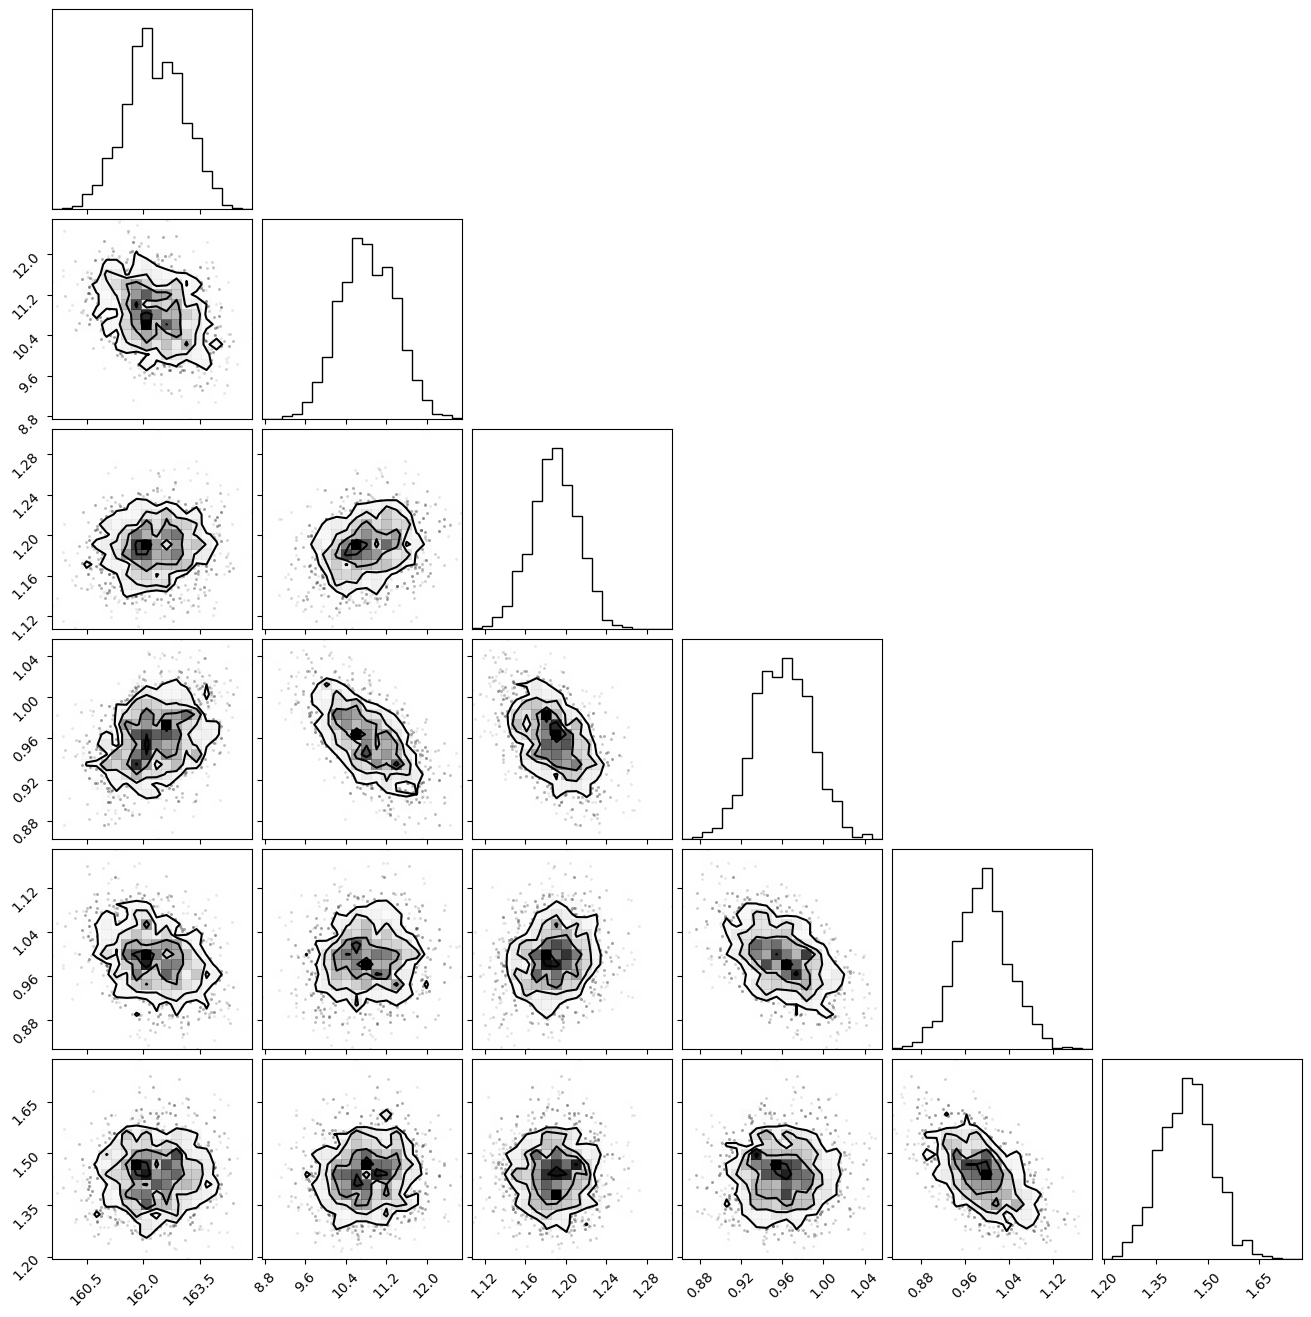

In [9]:
corner.corner(res);

(10, 288)

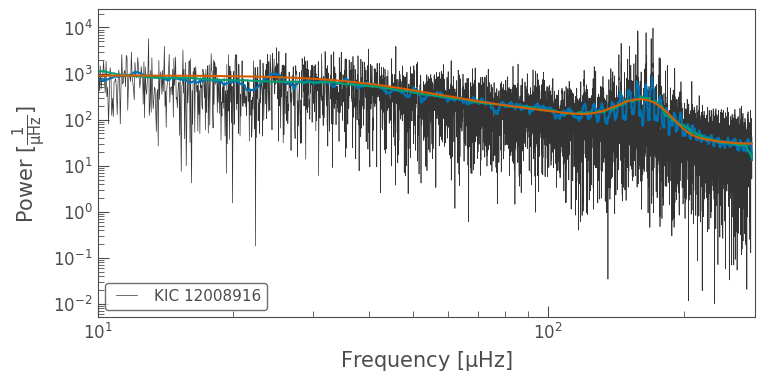

In [10]:
ax = pg.plot('log')
ax.plot(pg.frequency, pg.smooth(filter_width=2.0).power)
ax.plot(pg.frequency, pg.smooth(filter_width=20.0).power)
ax.plot(pg.frequency, tt.full_model(res.mean(axis=0)))
ax.set_xlim([10, 288])